# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
import dagshub
import optuna
import pmdarima 
import warnings
from ml.utils.utils import get_data, prepare_monthly_healthcare_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


e:\Learnings\Learning_curves\Call_Center_Traffic_Forecasting\call\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Dagshub Integration for MLflow Experiment Tracking

In [2]:
mlflow.is_tracking_uri_set()

False

In [3]:
dagshub.init(repo_owner='pramitde726', repo_name='Healthcare-Call-Center-Traffic-Forecasting', mlflow=True)

Accessing as pramitde726

Initialized MLflow to track repo "pramitde726/Healthcare-Call-Center-Traffic-Forecasting"

Repository pramitde726/Healthcare-Call-Center-Traffic-Forecasting initialized!

In [4]:
mlflow.get_tracking_uri()

'https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow'

In [5]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

## Ignore warnings
warnings.filterwarnings("ignore")

# Read the Data

In [6]:
df = get_data("CallCenterData", "raw")
df.head()


,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
0,31-Jan,631,8,6,2,19,1,4
1,28-Feb,633,9,7,3,27,1,3
2,31-Mar,766,4,4,2,24,1,1
3,30-Apr,768,12,6,3,32,1,1
4,31-May,1003,2,7,2,42,1,4


In [7]:
start_year = 2014 

In [8]:
analysis_df = prepare_monthly_healthcare_series(df, start_year=start_year)

In [9]:
analysis_df

index
2014-01-31      631
2014-02-28      633
2014-03-31      766
2014-04-30      768
2014-05-31     1003
              ...  
2024-08-31    20257
2024-09-30    19207
2024-10-31    23414
2024-11-30    23602
2024-12-31    20058
Freq: ME, Name: Healthcare, Length: 132, dtype: int64

In [10]:
y_train, y_test = temporal_train_test_split(analysis_df, test_size=12)

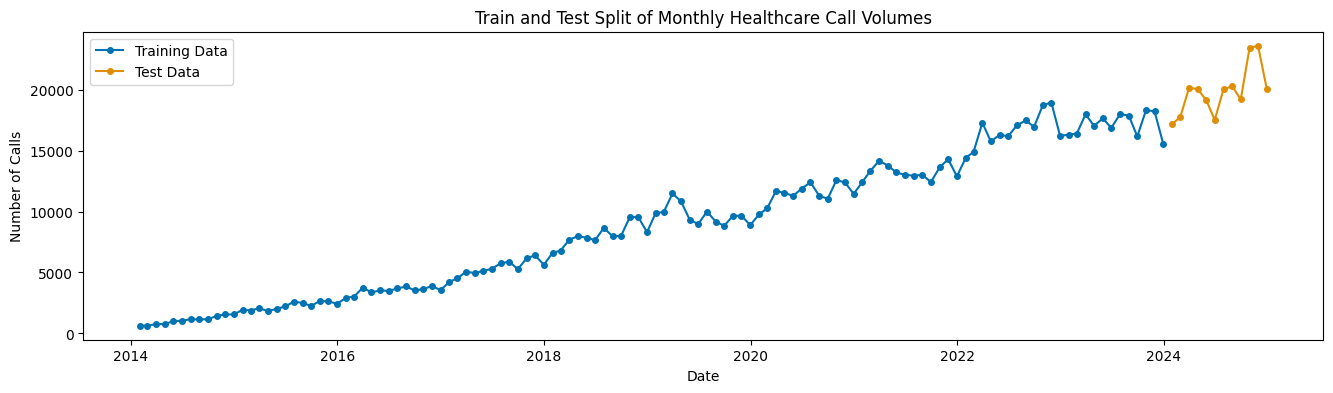

In [12]:
# Plot the train and test data
plot_series(y_train, y_test, labels=["Training Data", "Test Data"])
plt.title("Train and Test Split of Monthly Healthcare Call Volumes")
plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.show()



# Model Selection

In [41]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Model Selection")

<Experiment: artifact_location='mlflow-artifacts:/42f027a686ad402f956f5229fd5faf5e', creation_time=1742223160537, experiment_id='0', last_update_time=1742223160537, lifecycle_stage='active', name='Exp 1 - Model Selection', tags={}>

In [45]:
# Start MLflow run
with mlflow.start_run():
    models = {
        "ARIMA(0,1,1) - MA(1)": TransformedTargetForecaster([
            ("differencer", Differencer(lags=1)),
            ("forecaster", ARIMA(order=(0, 0, 1))),  
        ]),
        "ARIMA(1,1,0) - AR(1)": TransformedTargetForecaster([
            ("differencer", Differencer(lags=1)),
            ("forecaster", ARIMA(order=(1, 0, 0))),
        ]),
        "ARIMA(1,1,1) - ARMA(1,1)": TransformedTargetForecaster([
            ("differencer", Differencer(lags=1)),
            ("forecaster", ARIMA(order=(1, 0, 1))),
        ]),
    }

    results = {}
    fh = np.arange(1, len(y_test) + 1)  

    for model_name, model in models.items():
        with mlflow.start_run(nested=True):  # Nested run for each model
            mlflow.log_param("experiment_type", model_name) 

            model.fit(y_train)
            y_pred = model.predict(fh=fh)  
            y_pred = pd.Series(y_pred, index=y_test.index) 

            # Compute MAE
            mae = mean_absolute_error(y_test.values, y_pred.values)

            # Compute Directional Accuracy (DA)
            y_test_diff = y_test.diff().dropna().reset_index(drop=True)
            y_pred_diff = y_pred.diff().dropna().reset_index(drop=True)
            da = np.mean(np.sign(y_test_diff) == np.sign(y_pred_diff))

            # Extract fitted ARIMA model and log AIC/BIC
            try:
                arima_model = model.forecaster_  # Extract ARIMA model
                summary = arima_model.summary()
                aic = float(summary.tables[0].data[2][3])  # Extract AIC
                bic = float(summary.tables[0].data[3][3])  # Extract BIC
            except (AttributeError, IndexError, ValueError):
                aic, bic = None, None  # Handle errors gracefully

            results[model_name] = (mae, aic, bic)

            # Log metrics
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("DA", da)
            if aic is not None:
                mlflow.log_metric("AIC", aic)
            if bic is not None:
                mlflow.log_metric("BIC", bic)

            # Plot and Log Residual ACF and PACF
            residuals = y_test - y_pred
            max_lags_acf = min(12, len(residuals) - 1) 
            max_lags_pacf = min(12, (len(residuals) // 2) - 1)

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            plot_acf(residuals.dropna(), lags=max_lags_acf, ax=axes[0])
            axes[0].set_title(f"{model_name} Residual ACF")
            plot_pacf(residuals.dropna(), lags=max_lags_pacf, ax=axes[1])
            axes[1].set_title(f"{model_name} Residual PACF")
            
            mlflow.log_figure(fig, f"{model_name}_Residual_ACF_PACF.png")
            plt.close(fig)

    # Log best model based on lowest AIC
    best_model_name = min(results, key=lambda x: results[x][1] if results[x][1] is not None else float("inf"))
    mlflow.log_param("best_model", best_model_name)

    print(f"Model Selection Results:\n{results}")
    print(f"Best Model: {best_model_name}")


🏃 View run funny-midge-458 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0/runs/7ee8e71000eb41429b167baeea228b41
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0
🏃 View run enchanting-cow-950 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0/runs/3541753393d344578d2e943a7f839ccb
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0
🏃 View run righteous-wasp-844 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0/runs/a0fa16087ff642199cccd056e2647541
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/0
Model Selection Results:
{'ARIMA(0,1,1) - MA(1)': (2069.4716588574756, 1936.547, 1944.909), 'ARIMA(1,1,0) - AR(1)': (2861.39320070016

# Hyperparamter Tuning

## Fine-Tuning Strategy 
1. Parameters to Tune
Moving Average (q): This parameter controls the MA component of ARIMA. The best model has q=1, but we will explore values around it.

Differencing Order (d): Since d=1 performed well, we keep it fixed.

Auto-Regressive Order (p): Though the best model has p=0, we explore whether including autoregressive terms improves performance.

2. Optimization Objective
Minimize MAE: The goal is to select (p, q) that minimize the mean absolute error.

3. Search Space

- p ∈ [0, 5]
- q ∈ [0, 5]
- d = 1 (Fixed)

In [49]:
mlflow.set_experiment("Exp 2 - Best Model")

<Experiment: artifact_location='mlflow-artifacts:/535a331b02dc47bda746a88dc3f4350e', creation_time=1742652906969, experiment_id='1', last_update_time=1742652906969, lifecycle_stage='active', name='Exp 2 - Best Model', tags={}>

In [68]:
# Define Forecast Horizon
fh = np.arange(1, len(y_train) + 1) 

def objective(trial):
    p = trial.suggest_int("p", 0, 5)
    q = trial.suggest_int("q", 0, 5)
    d = 1  # Fixed differencing order

    try:
        with mlflow.start_run(nested=True):
            # Define sktime pipeline with differencing
            model = TransformedTargetForecaster([
                ("differencer", Differencer(lags=d)),
                ("forecaster", ARIMA(order=(p, 0, q)))  
            ])

            model.fit(y_train)

            # Forecast
            y_pred = model.predict(fh=fh)
            mae = mean_absolute_error(y_train, y_pred)

            # Log parameters & metrics to MLflow
            mlflow.log_params({"p": p, "d": d, "q": q})
            mlflow.log_metric("MAE", mae)

        return mae
    except Exception as e:
        return np.inf  # Return high value if ARIMA fails

In [69]:
# Run Optuna Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_p, best_q = study.best_params["p"], study.best_params["q"]

# Train final model with best parameters
best_model = TransformedTargetForecaster([
    ("differencer", Differencer(lags=1)),  
    ("forecaster", ARIMA(order=(best_p, 0, best_q)))
])

best_model.fit(y_train)

# Log best model in MLflow
with mlflow.start_run() as parent:
    mlflow.log_params({"p": best_p, "d": 1, "q": best_q})
    
    # Infer signature correctly
    signature = infer_signature(pd.DataFrame(y_train), pd.DataFrame(best_model.predict(fh=fh)))
    
    # Log the model
    mlflow.sklearn.log_model(
        sk_model=best_model, 
        artifact_path="best_model", 
        signature=signature
    )
    
    # Register the model
    result = mlflow.register_model(
        f"runs:/{parent.info.run_id}/best_model", 
        "healthcare_staging"
    )
    print(f"Registered model version: {result.version}")

print(f"Best ARIMA Order: ({best_p}, 1, {best_q})")

[I 2025-03-24 19:56:17,546] A new study created in memory with name: no-name-38a0c968-8b36-4662-be7e-1e35776fa5e0


🏃 View run bright-carp-605 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/482483f5a0c342d38e5f75e181d8a385
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:20,304] Trial 0 finished with value: 14164.945619180742 and parameters: {'p': 5, 'q': 2}. Best is trial 0 with value: 14164.945619180742.


🏃 View run bold-colt-273 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/2a92e24e4b654a3187758c12384fae85
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:22,753] Trial 1 finished with value: 16728.753084073083 and parameters: {'p': 0, 'q': 2}. Best is trial 0 with value: 14164.945619180742.


🏃 View run wistful-koi-568 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/e699e5613b6c4769b265b352e9b1d7e8
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:25,552] Trial 2 finished with value: 14660.227948304388 and parameters: {'p': 3, 'q': 4}. Best is trial 0 with value: 14164.945619180742.


🏃 View run exultant-seal-374 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/40cbe8f66d4c403f9611155be15ba464
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:27,852] Trial 3 finished with value: 15173.7765480196 and parameters: {'p': 1, 'q': 0}. Best is trial 0 with value: 14164.945619180742.


🏃 View run shivering-eel-45 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/d9fa1b0626cb4e228e23c88ee19f2aea
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:31,969] Trial 4 finished with value: 17018.77113173085 and parameters: {'p': 4, 'q': 5}. Best is trial 0 with value: 14164.945619180742.


🏃 View run efficient-auk-173 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/8cd048c846a649b9982cd945477616c9
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:36,984] Trial 5 finished with value: 16303.053824847819 and parameters: {'p': 4, 'q': 0}. Best is trial 0 with value: 14164.945619180742.


🏃 View run capable-skunk-268 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/1be2abd1742841c7a9b69b8f8cf23561
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:41,999] Trial 6 finished with value: 14145.99471867021 and parameters: {'p': 2, 'q': 4}. Best is trial 6 with value: 14145.99471867021.


🏃 View run popular-conch-302 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/a44fda7bccce4477badfcfe44f20e777
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:47,008] Trial 7 finished with value: 15917.21557483441 and parameters: {'p': 3, 'q': 1}. Best is trial 6 with value: 14145.99471867021.


🏃 View run bittersweet-wasp-323 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/3d63b074fd294bdd88b8a0e8921a0219
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:51,981] Trial 8 finished with value: 16004.904204162178 and parameters: {'p': 5, 'q': 1}. Best is trial 6 with value: 14145.99471867021.


🏃 View run loud-fish-826 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/44a780785f5541c79b314aea4b31b04f
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:56:56,995] Trial 9 finished with value: 15917.21557483441 and parameters: {'p': 3, 'q': 1}. Best is trial 6 with value: 14145.99471867021.


🏃 View run thundering-grub-896 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/74b915fc1c1c45ee8e10534066ccfd54
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:01,978] Trial 10 finished with value: 14125.441256697248 and parameters: {'p': 1, 'q': 4}. Best is trial 10 with value: 14125.441256697248.


🏃 View run enthused-croc-703 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/08738e8d9ac44e40a59fdf29a9b6a623
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:06,999] Trial 11 finished with value: 14125.441256697248 and parameters: {'p': 1, 'q': 4}. Best is trial 10 with value: 14125.441256697248.


🏃 View run welcoming-hare-83 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/8da0cd9a242e43e4b5715717876d7e0b
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:12,007] Trial 12 finished with value: 16376.761028454286 and parameters: {'p': 0, 'q': 4}. Best is trial 10 with value: 14125.441256697248.


🏃 View run unruly-duck-709 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/a778f058a4bf46c08203409e7a66d1db
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:16,993] Trial 13 finished with value: 16118.879214862094 and parameters: {'p': 1, 'q': 5}. Best is trial 10 with value: 14125.441256697248.


🏃 View run flawless-lark-799 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/ddfdba14cab04dceac521205f8c60001
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:21,988] Trial 14 finished with value: 15443.678434850377 and parameters: {'p': 1, 'q': 3}. Best is trial 10 with value: 14125.441256697248.


🏃 View run polite-lamb-940 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/f7bfa706a85147ecb8002251c537074a
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:27,016] Trial 15 finished with value: 15915.14050900423 and parameters: {'p': 2, 'q': 3}. Best is trial 10 with value: 14125.441256697248.


🏃 View run marvelous-mare-874 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/f9995cbeb827408d8995883aac5f6e5b
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:31,986] Trial 16 finished with value: 14125.441256697248 and parameters: {'p': 1, 'q': 4}. Best is trial 10 with value: 14125.441256697248.


🏃 View run likeable-lynx-32 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/a424400fee1c4ceb8e27dff9240c3bf0
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:36,980] Trial 17 finished with value: 17013.996394519378 and parameters: {'p': 0, 'q': 5}. Best is trial 10 with value: 14125.441256697248.


🏃 View run shivering-calf-363 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/9be3b0a65e54452b802b90aee61a72cc
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:42,008] Trial 18 finished with value: 15915.14050900423 and parameters: {'p': 2, 'q': 3}. Best is trial 10 with value: 14125.441256697248.


🏃 View run angry-chimp-877 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/2a72cb94c24a4856b8dc3eb26f3d168c
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1


[I 2025-03-24 19:57:46,982] Trial 19 finished with value: 14125.441256697248 and parameters: {'p': 1, 'q': 4}. Best is trial 10 with value: 14125.441256697248.
2025/03/24 19:59:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\PRAMIT~1\AppData\Local\Temp\tmp7hb00fxl\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'healthcare_staging' already exists. Creating a new version of this model...
2025/03/24 19:59:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: healthcare_staging, version 4
Created version '4' of model 'healthcare_staging'.


Registered model version: 4
🏃 View run chill-bug-529 at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1/runs/e32f9629efe1490cbb04bda192bc8195
🧪 View experiment at: https://dagshub.com/pramitde726/Healthcare-Call-Center-Traffic-Forecasting.mlflow/#/experiments/1
Best ARIMA Order: (1, 1, 4)


# Export data

In [31]:
train_path = "../artifacts/train.csv"
test_path = "../artifacts/test.csv"

In [ ]:
y_train.to_csv(train_path)
y_test.to_csv(test_path)

# Model Registry

In [55]:
# Initialize an MLflow Client
client = MlflowClient()

In [56]:
# Define the model name
model_name = "healthcare_staging" 

In [57]:
def assign_alias_to_stage(model_name: str, alias: str) -> None:
    """
    Assign an alias to the latest version of a registered model.

    :param model_name: The name of the registered model.
    :type model_name: str
    :param alias: The alias to assign to the model version.
    :type alias: str
    :return: None
    :rtype: None
    """
    latest_mv: Any = client.get_latest_versions(model_name)[0]  
    client.set_registered_model_alias(model_name, alias, latest_mv.version)
    

In [58]:
assign_alias_to_stage(model_name=model_name, alias="lat")

In [59]:
# Fetch model URI using alias 
model_uri = f"models:/{model_name}@lat"

# Load the best model
best_model = mlflow.sklearn.load_model(model_uri)

In [60]:
best_model.forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -952.247
Date:                Mon, 24 Mar 2025   AIC                           1918.495
Time:                        19:53:12   BIC                           1938.007
Sample:                    01-31-2014   HQIC                          1926.419
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    265.5823    129.758      2.047      0.041      11.261     519.903
ar.L1         -0.2683      0.109     -2.456      0.014      -0.482      -0.054
ar.L2         -0.9834      0.028    -35.384      0.000      -1.038      -0.929
ar.L3         -0.2434      0.113     -2.155      0.031      -0.465      -0.022
ma.L1         -0.1502      0.050     -3.029      0.002      -0.247      -0.053
ma.L2          0.9932      0.213      4.670      0.000       0.576       1.410
sigma2      4.869e+05   1.15e+05      4.243      0.000    2.62e+05    7.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                16.58
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              13.50   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
fh_test = np.arange(1, len(y_test) + 1)
y_pred = best_model.predict(fh=fh_test)  
y_pred = pd.Series(y_pred, index=y_test.index) 

# Compute Directional Accuracy (DA)
y_test_diff = y_test.diff().dropna().reset_index(drop=True)
y_pred_diff = y_pred.diff().dropna().reset_index(drop=True)
da = np.mean(np.sign(y_test_diff) == np.sign(y_pred_diff))
print("Directional Accuracy (DA):", da)

Directional Accuracy (DA): 0.6363636363636364


In [67]:
mae = mean_absolute_error(y_test, y_pred)
mae


2776.067806113557

In [64]:
# Get in-sample (training) predictions
fh_train = ForecastingHorizon(y_train.index, is_relative=False)
y_train_pred = best_model.predict(fh=fh_train)

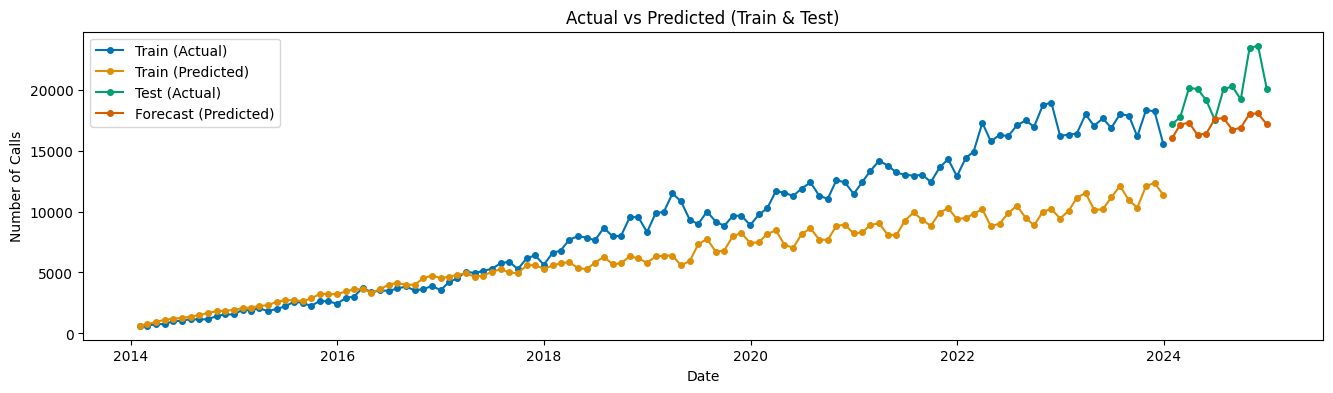

In [65]:
# Plot actual vs. predicted values along with training predictions
plot_series(y_train, y_train_pred, y_test, y_pred, labels=["Train (Actual)", "Train (Predicted)", "Test (Actual)", "Forecast (Predicted)"])
plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.title("Actual vs Predicted (Train & Test)")
plt.show()

In [73]:
(
    pd.read_csv(test_path)
    .rename(columns={"Unnamed: 0": "Date"})
    .assign(Date=lambda x: pd.to_datetime(x["Date"]))
    .set_index("Date")
    ["Healthcare"]
)    


Date
2024-01-31    17167
2024-02-29    17749
2024-03-31    20144
2024-04-30    20054
2024-05-31    19128
2024-06-30    17515
2024-07-31    20041
2024-08-31    20257
2024-09-30    19207
2024-10-31    23414
2024-11-30    23602
2024-12-31    20058
Name: Healthcare, dtype: int64

In [72]:
y_test

2024-01-31    17167
2024-02-29    17749
2024-03-31    20144
2024-04-30    20054
2024-05-31    19128
2024-06-30    17515
2024-07-31    20041
2024-08-31    20257
2024-09-30    19207
2024-10-31    23414
2024-11-30    23602
2024-12-31    20058
Freq: ME, Name: Healthcare, dtype: int64